## A/B Test: StandardScaler vs QuantileTransformer (Einstein COVID-19)

This temporary notebook compares two preprocessing strategies for clustering:

- **Pipeline A (Standard)**: KNN Imputer → StandardScaler → PCA (95% variance) → KMeans (k=3)
- **Pipeline B (Advanced)**: KNN Imputer → QuantileTransformer → PCA (95% variance) → KMeans (k=3)

We evaluate:
- **Silhouette score** (cluster separation)
- **ICU admission rate per cluster**
- **Cluster size distribution**

Goal: check which preprocessing better separates high-risk ICU patients.

In [4]:
import sys
from pathlib import Path

ROOT = Path.cwd().parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sns.set_style("whitegrid")
plt.rcParams["figure.dpi"] = 100

### 1. Load Raw Data (Einstein COVID-19)

We try to load from the same raw file used in the main project. Adjust paths if needed.

In [5]:
from pathlib import Path

RAW_DIR = ROOT / "data" / "raw"

# Try a couple of common filenames used in this project
candidates = [
    RAW_DIR / "dataset.xlsx",
    RAW_DIR / "dataset - All.csv",
    RAW_DIR / "dataset_All.csv",
]

raw_path = None
for p in candidates:
    if p.exists():
        raw_path = p
        break

if raw_path is None:
    raise FileNotFoundError(f"Could not find raw dataset in {RAW_DIR}. Checked: {candidates}")

print(f"Using raw file: {raw_path}")

if raw_path.suffix.lower() in {".xlsx", ".xls"}:
    df_raw = pd.read_excel(raw_path)
else:
    df_raw = pd.read_csv(raw_path)

print(df_raw.shape)
df_raw.head()

Using raw file: c:\Users\amitf\Documents\פרויקט בלמידת מכונה וסטטיסטיקה בישומים רפואים\data\raw\dataset.xlsx
(5644, 111)


,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,...,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
0,44477f75e8169d2,13,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126e9dd13932f68,17,negative,0,0,0,0.236515,-0.02234,-0.517413,0.010677,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a46b4402a0e5696,8,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f7d619a94f97c45,5,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,d9e41465789c2b5,15,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2. Select Cohort (≥10 non-null values in main lab panel)

We mimic the main project: keep patients with at least 10 non-null values in a set of key lab tests.

If some of these columns are missing, we silently drop them from the panel.

In [6]:
# Define main lab columns (adjusted to your dataset naming)
MAIN_LABS = [
    "Hematocrit",
    "Hemoglobin",
    "Red blood Cells",
    "Leukocytes",
    "Lymphocytes",
    "Platelets",
    "Urea",
    "Creatinine",
    "Sodium",
    "Potassium",
    "Proteina C reativa mg/dL",
    "Neutrophils",
    "Eosinophils",
    "Basophils",
    "Monocytes",
    "Mean corpuscular volume (MCV)",
    "Mean corpuscular hemoglobin (MCH)",
    "Mean corpuscular hemoglobin concentration (MCHC)",
    "Red blood cell distribution width (RDW)",
    "Albumin",
]

# Keep only columns that actually exist
available_labs = [c for c in MAIN_LABS if c in df_raw.columns]
print(f"Using {len(available_labs)} lab features out of {len(MAIN_LABS)} candidates")

icu_col = "Patient addmited to intensive care unit (1=yes, 0=no)"
if icu_col not in df_raw.columns:
    raise KeyError(f"ICU column '{icu_col}' not found in raw dataframe.")

# Count non-null labs per patient in this panel
lab_counts = df_raw[available_labs].notna().sum(axis=1)
mask = lab_counts >= 10
df_cohort = df_raw.loc[mask].copy()

print(f"Cohort size: {df_cohort.shape[0]} patients (out of {df_raw.shape[0]})")
df_cohort[available_labs + [icu_col]].head()

Using 19 lab features out of 20 candidates
Cohort size: 602 patients (out of 5644)


,Hematocrit,Hemoglobin,Red blood Cells,Leukocytes,Lymphocytes,Platelets,Urea,Creatinine,Sodium,Potassium,Proteina C reativa mg/dL,Neutrophils,Eosinophils,Basophils,Monocytes,Mean corpuscular volume (MCV),Mean corpuscular hemoglobin (MCH),Red blood cell distribution width (RDW),Albumin,"Patient addmited to intensive care unit (1=yes, 0=no)"
1,0.236515,-0.022340,0.102004,-0.094610,0.318366,-0.517413,1.198059,2.089928,0.862512,-0.305787,-0.147895,-0.619086,1.482158,-0.223767,0.357547,0.166192,-0.292269,-0.625073,NaN,0
8,-1.571682,-0.774212,-0.850035,0.364550,-0.005738,1.429667,-0.067309,-1.838623,0.503132,0.930020,-0.286986,-0.127395,1.018625,-0.223767,0.068652,-1.336024,0.178175,-0.978899,NaN,0
15,-0.747693,-0.586244,-1.361315,-0.884923,-1.114514,-0.429480,-0.811643,-0.908177,-0.215628,0.435697,NaN,0.880570,-0.666950,0.081693,1.276759,1.668409,1.746323,-1.067355,NaN,0
18,0.991838,0.792188,0.542763,-0.211488,0.045436,0.072992,NaN,NaN,NaN,NaN,-0.487674,0.265957,-0.709090,-0.834685,-0.220244,0.606842,0.334989,0.171035,NaN,0
22,0.190738,-0.147652,-0.127191,-1.132592,0.002791,-0.668155,-1.332677,-0.908177,-0.575008,-0.552949,NaN,-0.422410,-0.709090,0.387152,2.012129,0.566783,-0.083183,0.613318,NaN,0


### 3. KNN Imputation

We apply the same missing-data strategy in both pipelines: **KNNImputer(n_neighbors=5)** on the lab panel.

In [7]:
X_labs = df_cohort[available_labs].astype(float)
y_icu = df_cohort[icu_col].astype(float)

imputer = KNNImputer(n_neighbors=5)
X_imputed = imputer.fit_transform(X_labs)
X_imputed = pd.DataFrame(X_imputed, columns=available_labs, index=df_cohort.index)

X_imputed.head()

,Hematocrit,Hemoglobin,Red blood Cells,Leukocytes,Lymphocytes,Platelets,Urea,Creatinine,Sodium,Potassium,Proteina C reativa mg/dL,Neutrophils,Eosinophils,Basophils,Monocytes,Mean corpuscular volume (MCV),Mean corpuscular hemoglobin (MCH),Red blood cell distribution width (RDW),Albumin
1,0.236515,-0.022340,0.102004,-0.094610,0.318366,-0.517413,1.198059,2.089928,0.862512,-0.305787,-0.147895,-0.619086,1.482158,-0.223767,0.357547,0.166192,-0.292269,-0.625073,0.411843
8,-1.571682,-0.774212,-0.850035,0.364550,-0.005738,1.429667,-0.067309,-1.838623,0.503132,0.930020,-0.286986,-0.127395,1.018625,-0.223767,0.068652,-1.336024,0.178175,-0.978899,0.361806
15,-0.747693,-0.586244,-1.361315,-0.884923,-1.114514,-0.429480,-0.811643,-0.908177,-0.215628,0.435697,-0.472970,0.880570,-0.666950,0.081693,1.276759,1.668409,1.746323,-1.067355,-0.138564
18,0.991838,0.792188,0.542763,-0.211488,0.045436,0.072992,0.007125,0.325526,-0.359380,0.188535,-0.487674,0.265957,-0.709090,-0.834685,-0.220244,0.606842,0.334989,0.171035,0.812139
22,0.190738,-0.147652,-0.127191,-1.132592,0.002791,-0.668155,-1.332677,-0.908177,-0.575008,-0.552949,-0.114911,-0.422410,-0.709090,0.387152,2.012129,0.566783,-0.083183,0.613318,0.311769


### 4. Helper: Run One Pipeline

This function runs:

- scaler / transformer
- PCA (95% variance)
- KMeans (k=3)

and returns:

- labels
- silhouette score
- ICU rate per cluster
- cluster sizes

In [8]:
def run_pipeline(name, X, y_icu, scaler):
    """Run scaling → PCA → KMeans and compute metrics."""
    # 1) Scale / transform
    X_scaled = scaler.fit_transform(X)

    # 2) PCA to 95% variance
    pca = PCA(n_components=0.95, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    # 3) KMeans clustering (k=3)
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_pca)

    # 4) Silhouette score
    sil = silhouette_score(X_pca, labels)

    # 5) ICU rate per cluster
    tmp = pd.DataFrame({"cluster": labels, "icu": y_icu.values}, index=X.index)
    icu_rate = tmp.groupby("cluster")["icu"].mean() * 100.0
    counts = tmp["cluster"].value_counts().sort_index()

    result = {
        "name": name,
        "labels": labels,
        "silhouette": sil,
        "icu_rate": icu_rate,
        "counts": counts,
    }
    return result

### 5. Run Pipelines A and B

- **A:** StandardScaler
- **B:** QuantileTransformer (normal output)

In [9]:
# Pipeline A: StandardScaler
res_std = run_pipeline(
    name="StandardScaler",
    X=X_imputed,
    y_icu=y_icu,
    scaler=StandardScaler(),
)

# Pipeline B: QuantileTransformer
res_qt = run_pipeline(
    name="QuantileTransformer",
    X=X_imputed,
    y_icu=y_icu,
    scaler=QuantileTransformer(output_distribution="normal", random_state=42),
)

print("Silhouette scores:")
print(f"  StandardScaler:     {res_std['silhouette']:.4f}")
print(f"  QuantileTransformer: {res_qt['silhouette']:.4f}")

print("\nCluster sizes (StandardScaler):")
print(res_std["counts"])
print("\nCluster sizes (QuantileTransformer):")
print(res_qt["counts"])

print("\nICU rate per cluster (%): StandardScaler")
print(res_std["icu_rate"].round(2))
print("\nICU rate per cluster (%): QuantileTransformer")
print(res_qt["icu_rate"].round(2))

Silhouette scores:
  StandardScaler:     0.1015
  QuantileTransformer: 0.1238

Cluster sizes (StandardScaler):
cluster
0    178
1    217
2    207
Name: count, dtype: int64

Cluster sizes (QuantileTransformer):
cluster
0    232
1    258
2    112
Name: count, dtype: int64

ICU rate per cluster (%): StandardScaler
cluster
0    11.80
1     1.84
2     1.93
Name: icu, dtype: float64

ICU rate per cluster (%): QuantileTransformer
cluster
0     4.31
1     1.16
2    14.29
Name: icu, dtype: float64


c:\Users\amitf\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (602). n_quantiles is set to n_samples.
  warnings.warn(


### 6. Visualization: ICU Rate Comparison

We build a long-format DataFrame and plot a side-by-side bar chart of ICU rates for each method and cluster.

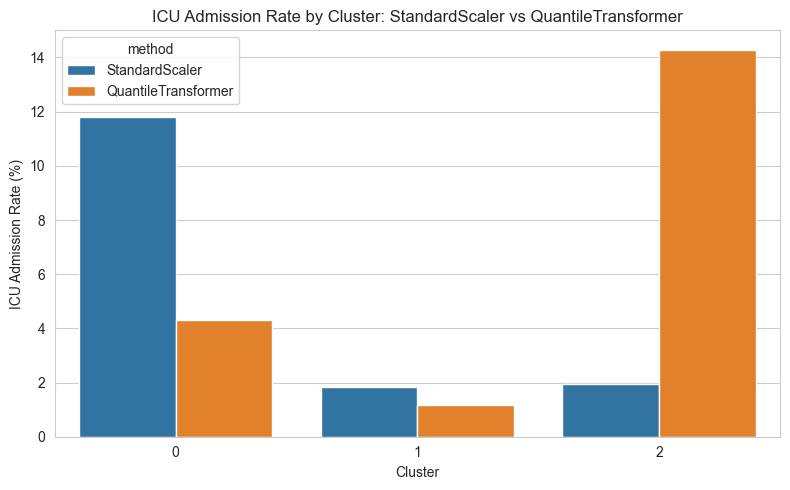

In [10]:
# Build comparison DataFrame
records = []
for method, res in [("StandardScaler", res_std), ("QuantileTransformer", res_qt)]:
    for cluster, rate in res["icu_rate"].items():
        records.append({
            "method": method,
            "cluster": int(cluster),
            "icu_rate": float(rate),
        })

df_plot = pd.DataFrame(records)

plt.figure(figsize=(8, 5))
sns.barplot(
    data=df_plot,
    x="cluster",
    y="icu_rate",
    hue="method",
)
plt.title("ICU Admission Rate by Cluster: StandardScaler vs QuantileTransformer")
plt.xlabel("Cluster")
plt.ylabel("ICU Admission Rate (%)")
plt.tight_layout()
plt.show()

### 7. Interpretation

- Compare **Silhouette scores**: higher = better geometric separation.
- Look at **ICU rates**: which method produces one cluster with clearly higher ICU %, and cleaner separation between low/medium/high-risk clusters?

If the QuantileTransformer pipeline yields a clearer high-ICU cluster (and/or higher silhouette), it supports using the advanced scaling in the main project.
If StandardScaler is similar or better, the simpler pipeline may be sufficient.